# Introduction to ARIMA Models
We'll investigate a variety of different forecasting models, they all stem from ARIMA.

<strong>ARIMA</strong>, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

<strong>Moving Averages</strong> we've already seen with EWMA and the Holt-Winters Method.<br>
<strong>Integration</strong> will apply differencing to make a time series stationary, which ARIMA requires.<br>
<strong>Autoregression</strong> is explained in detail in the next section. Here we're going to correlate a current time series with a lagged version of the same series.<br>
Once we understand the components, we'll investigate how to best choose the $p$, $d$ and $q$ values required by the model.

# AR(p)
# Autoregressive Model
In a moving average model as we saw with Holt-Winters, we forecast the variable of interest using a linear combination of predictors. In our example we forecasted numbers of airline passengers in thousands based on a set of level, trend and seasonal predictors.

In an autoregression model, we forecast using a linear combination of <em>past values</em> of the variable. The term <em>autoregression</em> describes a regression of the variable against itself. An autoregression is run against a set of <em>lagged values</em> of order $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.

Note that the lag coeffients are usually less than one, as we usually restrict autoregressive models to stationary data.<br>
Specifically, for an <strong>AR(1)</strong> model: $-1 \lt \phi_1 \lt 1$<br>
and for an <strong>AR(2)</strong> model: $-1 \lt \phi_2 \lt 1, \ \phi_1 + \phi_2 \lt 1, \ \phi_2 - \phi_1 \lt 1$<br>

Models <strong>AR(3)</strong> and higher become mathematically very complex. Fortunately statsmodels does all the heavy lifting for us.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AR.html'>ar_model.AR</a></strong><font color=black>(endog[, dates, freq, missing])</font>&nbsp;&nbsp;Autoregressive AR(p) model<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.ARResults.html'>ar_model.ARResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Class to hold results from fitting an AR model</tt>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.ar_model import AR,ARResults

# Load the U.S. Population dataset
df = pd.read_csv('../Data/uspopulation.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [2]:
df.head()

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699


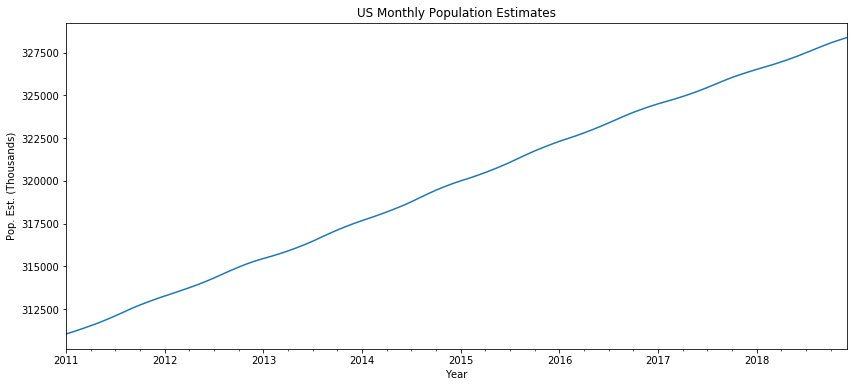

In [3]:
title = 'US Monthly Population Estimates'
ylabel = 'Pop. Est. (Thousands)'
xlabel = 'Year' # we don't really need a label here

ax = df['PopEst'].plot(figsize=(14,6), title=title);
ax.autoscale(axis='x',tight=True)
ax.set(title=title, ylabel=ylabel, xlabel=xlabel);

## Split the data into train/test sets

In [4]:
len(df)

96

In [5]:
train = df.iloc[:84]
test = df.iloc[84:]

## Fit an AR(1) Model

In [6]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [8]:
model = AR(train['PopEst'])
AR1fit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 1
Coefficients:
const        148.163961
L1.PopEst      0.999536
dtype: float64


In [10]:
# There's a slight difference between the object returned by the Holt-Winters Exponential Smoothing .fit() method 
# and that returned by AR. 
# The Holt-Winters object uses .forecast() for predicted values, while AR uses .predict().

start = len(train)
end = len(train) + len(test) - 1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename("AR(1) Predictions")

In [11]:
predictions1

2018-01-01    326374.750802
2018-02-01    326371.503110
2018-03-01    326368.256926
2018-04-01    326365.012247
2018-05-01    326361.769074
2018-06-01    326358.527406
2018-07-01    326355.287241
2018-08-01    326352.048579
2018-09-01    326348.811420
2018-10-01    326345.575763
2018-11-01    326342.341606
2018-12-01    326339.108951
Freq: MS, Name: AR(1) Predictions, dtype: float64

In [12]:
# Comparing predictions to expected values
for i in range(len(predictions1)):
    print(f"predicted={predictions1[i]:<11.10}, expected={test['PopEst'][i]}")

predicted=326374.7508, expected=326527
predicted=326371.5031, expected=326669
predicted=326368.2569, expected=326812
predicted=326365.0122, expected=326968
predicted=326361.7691, expected=327134
predicted=326358.5274, expected=327312
predicted=326355.2872, expected=327502
predicted=326352.0486, expected=327698
predicted=326348.8114, expected=327893
predicted=326345.5758, expected=328077
predicted=326342.3416, expected=328241
predicted=326339.109 , expected=328393


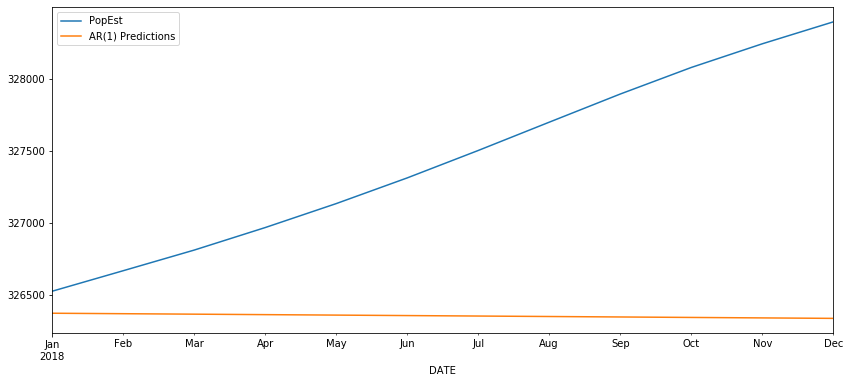

In [13]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True,figsize=(14,6));

## Fit an AR(2) Model

In [15]:
model2 = AR(train['PopEst'])
AR2fit = model2.fit(maxlag=2,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')

Lag: 2
Coefficients:
const        135.427091
L1.PopEst      1.996654
L2.PopEst     -0.997079
dtype: float64


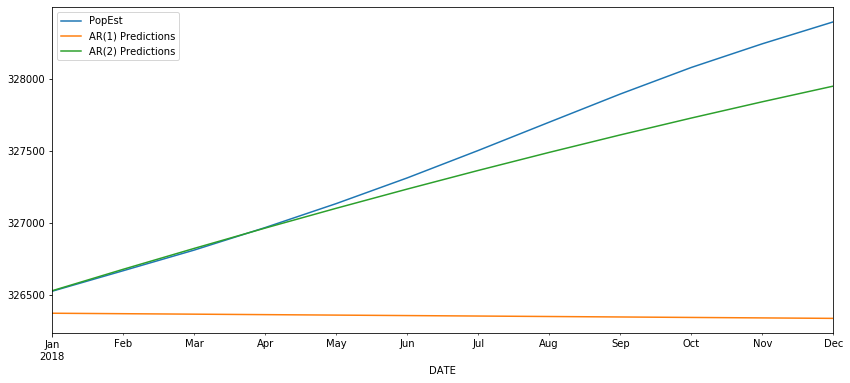

In [16]:
start=len(train)
end=len(train)+len(test)-1
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

test['PopEst'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(14,6));

## Fit an AR(p) model where statsmodels chooses p

This time we'll omit the maxlag argument in AR.fit() and let statsmodels choose a p-value for us.

In [17]:
model3 = AR(train['PopEst'])
ARfit = model3.fit(method='mle')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 11
Coefficients:
const         96.156267
L1.PopEst      2.215150
L2.PopEst     -2.048575
L3.PopEst      1.830671
L4.PopEst     -1.728297
L5.PopEst      1.125658
L6.PopEst     -1.113146
L7.PopEst      1.179305
L8.PopEst     -0.493263
L9.PopEst      0.270457
L10.PopEst    -0.231421
L11.PopEst    -0.006842
dtype: float64


In [18]:
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(11) Predictions'

predictions11 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

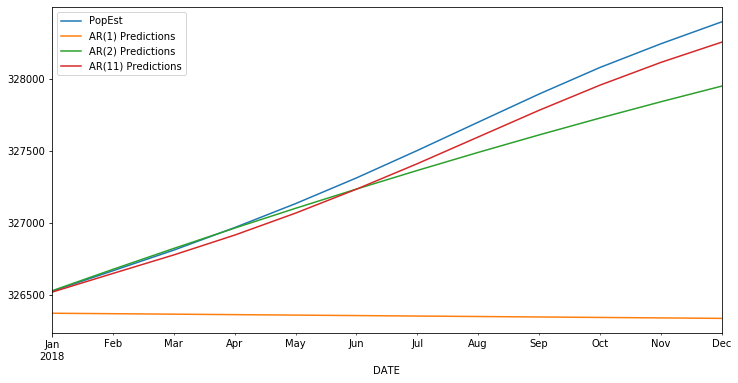

In [19]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions11.plot(legend=True,figsize=(12,6));

## Evaluate the Model
It helps to have a means of comparison between two or more models. One common method is to compute the Mean Squared Error (MSE), available from scikit-learn


In [20]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(11)']
preds = [predictions1, predictions2, predictions11]  # these are variables, not strings!

for i in range(3):
    error = mean_squared_error(test['PopEst'], preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error: 1542491.061
AR(2) Error:  52706.4653
AR(11) Error: 8134.846298


We see right away how well AR(11) outperformed the other two models.

Another method is the <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike information criterion</a> (AIC), which does a better job of evaluating models by avoiding overfitting.<br>
Fortunately this is available directly from the fit model object.

In [21]:
modls = [AR1fit,AR2fit,ARfit]

for i in range(3):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: 10.533
AR(2) AIC: 5.1541
AR(11) AIC: 3.7123


## Forecasting

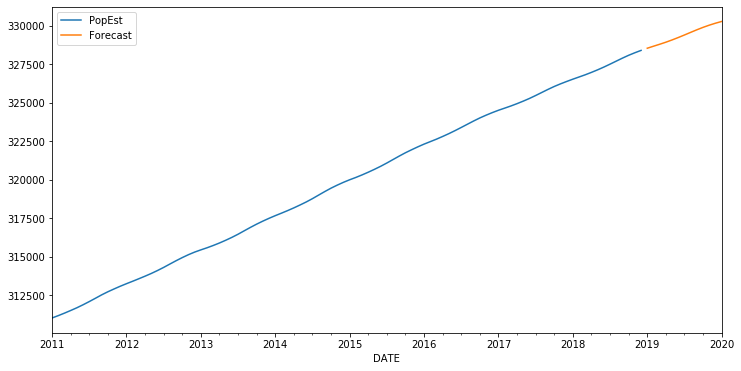

In [22]:
# First, retrain the model on the full dataset
model = AR(df['PopEst'])

# Next, fit the model
ARfit = model.fit(maxlag=11,method='mle')

# Make predictions
fcast = ARfit.predict(start=len(df), end=len(df)+12, dynamic=False).rename('Forecast')

# Plot the results
df['PopEst'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6));

# Choosing ARIMA Orders

* Goals
  * Understand PDQ terms for ARIMA (slides)
  * Understand how to choose orders manually from ACF and PACF
  * Understand how to use automatic order selection techniques using the functions below
  
Before we can apply an ARIMA forecasting model, we need to review the components of one.<br>
ARIMA, or Autoregressive Independent Moving Average is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period.
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt>
<strong>
<a href='https://www.alkaline-ml.com/pmdarima/user_guide.html#user-guide'>pmdarima.auto_arima</a></strong><font color=black>(y[,start_p,d,start_q, …])</font>&nbsp;&nbsp;&nbsp;Returns the optimal order for an ARIMA model<br>

<h3>Optional Function (see note below):</h3>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.arma_order_select_ic.html'>stattools.arma_order_select_ic</a></strong><font color=black>(y[, max_ar, …])</font>&nbsp;&nbsp;Returns information criteria for many ARMA models<br><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.x13.x13_arima_select_order.html'>x13.x13_arima_select_order</a></strong><font color=black>(endog[, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Perform automatic seasonal ARIMA order identification using x12/x13 ARIMA</tt></div>

In [23]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load a non-stationary dataset
df1 = pd.read_csv('../Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a stationary dataset
df2 = pd.read_csv('../Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

## pmdarima Auto-ARIMA

In [24]:
# This is a third-party tool separate from statsmodels.
from pmdarima import auto_arima

In [25]:
help(auto_arima)

Help on function auto_arima in module pmdarima.arima.auto:

auto_arima(y, exogenous=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=False, error_action='warn', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept=True, sarimax_kwargs=None, **fit_args)
    Automatically discover the optimal order for an ARIMA model.
    
    The auto-ARIMA process seeks to identify the most optimal
    parameters for an ``ARIMA`` model, settling on a single fitted ARIMA model.
    This process is based on the commonly-used R function,
    ``forecast::auto.arima``

In [26]:
# stationary dataset
auto_arima(df2['Births'])

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [28]:
auto_arima(df2['Births'],error_action='ignore').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1226.077
Date:                Tue, 12 May 2020   AIC                           2460.154
Time:                        13:19:08   BIC                           2475.743
Sample:                             0   HQIC                          2466.350
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0132      0.014      0.975      0.330      -0.013       0.040
ar.L1          0.1299      0.059      2.217      0.027       0.015       0.245
ma.L1         -0.9694      0.016    -62.235      0.000      -1.000      -0.939
sigma2        48.9989      3.432     14.279      0.000      42.273      55.725
===================================================================================
Ljung-Box (Q):                       36.69   Jarque-Bera (JB):                26.17
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.58
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This shows a recommended (p,d,q) ARIMA Order of (1,1,1), with no seasonal_order component.

We can see how this was determined by looking at the stepwise results. The recommended order is the one with the lowest <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike information criterion</a> or AIC score. Note that the recommended model may <em>not</em> be the one with the closest fit. The AIC score takes complexity into account, and tries to identify the best <em>forecasting</em> model.

In [30]:
stepwise_fit = auto_arima(df2['Births'],start_p=0,start_q=0,
                        max_p=6, max_q=3, m=12,
                        seasonal=False,
                         d=None, trace=True,
                         error_action='ignore', # we don't want to know if an order does not work
                         suppress_warnings=True,# we don't want convergence warnings
                         stepwise=True)         # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2650.760, BIC=2658.555, Time=0.024 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2565.234, BIC=2576.925, Time=0.085 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2463.584, BIC=2475.275, Time=0.120 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=2648.768, BIC=2652.665, Time=0.014 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2460.154, BIC=2475.743, Time=0.240 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2461.271, BIC=2480.757, Time=0.307 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2460.752, BIC=2480.238, Time=0.585 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2460.722, BIC=2476.311, Time=0.233 seconds
Fit ARIMA: (2,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1226.077
Date:                Tue, 12 May 2020   AIC                           2460.154
Time:                        13:25:15   BIC                           2475.743
Sample:                             0   HQIC                          2466.350
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0132      0.014      0.975      0.330      -0.013       0.040
ar.L1          0.1299      0.059      2.217      0.027       0.015       0.245
ma.L1         -0.9694      0.016    -62.235      0.000      -1.000      -0.939
sigma2        48.9989      3.432     14.279      0.000      42.273      55.725
===================================================================================
Ljung-Box (Q):                       36.69   Jarque-Bera (JB):                26.17
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.58
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# Non-stationary data
stepwise_fit = auto_arima(df1['Thousands of Passengers'], start_p=1, start_q=1,
                          max_p=6, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1024.824, BIC=1039.200, Time=0.418 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1033.479, BIC=1039.229, Time=0.019 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1022.316, BIC=1033.817, Time=0.314 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1022.904, BIC=1034.405, Time=0.345 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1031.508, BIC=1034.383, Time=0.019 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1022.343, BIC=1030.968, Time=0.114 seconds
Fit ARIMA: (1, 1, 0)x(2, 1, 0, 12) (constant=True); AIC=1021.137, BIC=1035.513, Time=1.008 seconds
Fit ARIMA: (1, 1, 0)x(2, 1, 1, 12) (constant=True); AIC=1017.164, BIC=1034.415, Time=3.923 seconds
Near non-invertible roots for order (1, 1, 0)(2, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -501.922
Date:                            Tue, 12 May 2020   AIC                           1015.844
Time:                                    13:26:37   BIC                           1033.095
Sample:                                         0   HQIC                          1022.854
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.033      0.013      0.990      -0.065       0.066
ma.L1         -0.4235      0.068     -6.194      0.000      -0.558      -0.290
ar.S.L12       0.6663      0.158      4.229      0.000       0.358       0.975
ar.S.L24       0.3318      0.096      3.469      0.001       0.144       0.519
ma.S.L12      -0.9712      1.091     -0.890      0.373      -3.109       1.167
sigma2       110.8287     98.274      1.128      0.259     -81.785     303.443
===================================================================================
Ljung-Box (Q):                       53.12   Jarque-Bera (JB):                 7.55
Prob(Q):                              0.08   Prob(JB):                         0.02
Heteroskedasticity (H):               2.82   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## statsmodels ARMA_Order_Select_IC
statsmodels has a selection tool to find orders for ARMA models on stationary data.

In [32]:
from statsmodels.tsa.stattools import arma_order_select_ic

In [34]:
help(arma_order_select_ic)

Help on function arma_order_select_ic in module statsmodels.tsa.stattools:

arma_order_select_ic(y, max_ar=4, max_ma=2, ic='bic', trend='c', model_kw=None, fit_kw=None)
    Compute information criteria for many ARMA models.
    
    Parameters
    ----------
    y : array_like
        Array of time-series data.
    max_ar : int
        Maximum number of AR lags to use. Default 4.
    max_ma : int
        Maximum number of MA lags to use. Default 2.
    ic : str, list
        Information criteria to report. Either a single string or a list
        of different criteria is possible.
    trend : str
        The trend to use when fitting the ARMA models.
    model_kw : dict
        Keyword arguments to be passed to the ``ARMA`` model.
    fit_kw : dict
        Keyword arguments to be passed to ``ARMA.fit``.
    
    Returns
    -------
    Bunch
        Dict-like object with attribute access. Each ic is an attribute with a
        DataFrame for the results. The AR order used is the row ind

In [35]:
arma_order_select_ic(df2['Births'])

{'bic':              0            1            2
 0  2502.581666  2494.238827  2494.731525
 1  2490.780306  2484.505386  2486.223523
 2  2491.963234  2485.782753  2491.097209
 3  2496.498618  2491.061564  2496.961178
 4  2501.491891  2504.012652  2498.329743,
 'bic_min_order': (1, 1)}

In [36]:
arma_order_select_ic(df1['Thousands of Passengers'])

{'bic':              0            1            2
 0  1796.307207  1627.771967  1534.002384
 1  1437.088819  1421.627523  1425.899321
 2  1425.518037  1423.098290  1465.346790
 3  1425.191373  1413.093308  1400.575367
 4  1427.576572  1528.552879  1414.849802,
 'bic_min_order': (3, 2)}